# Using Self-Attention & Transformers for NLP (Language Translation)
**Ben Paulson**

**Introduction:**
Based off knowledge gained from analyzing the initial implementaiton of a transformer in ["Attention Is All You Need"](https://arxiv.org/pdf/1706.03762.pdf) from Google in 2017, their work can be replicated -- and even trained using ROSIE -- in order to break down the individual components and their relationships within the overall structure of the Transformer.<br/>
The transformer architecture has been a revolutionary piece of knowledge provided to the world of sequence processing. As a seq2seq model, multiple implementations -- including modern BERT and GPT -- have used variations of this architecture to provide parallelizable throughput of input sequences, accept large input sequences with only a limit of onboard memory, and still provide generalized insights during the decoding process of the embedding space due to the introduction of self-attention.

**Additional Workshop Outline Found Here:** https://www.tensorflow.org/text/tutorials/transformer

## Part 1: Data Importing
Pull the paired-data of English and Portugese sentences from Tensorflow, as well as a pre-trained tokenizer.

In [1]:
# Basic Python imports
import os
import logging
import time
import argparse
from datetime import datetime

# Tensorflow Packages
import tensorflow_datasets as tfds
import tensorflow_text as tt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model

# Other Outside libraries
import numpy as np
import matplotlib.pyplot as plt

2023-05-11 14:05:45.839239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 14:05:45.960098: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-11 14:05:47.891558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/us

**Get the Data from Tensorflow**

In [2]:
# English to Portugese
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                              with_info = True,
                              as_supervised = True)

train_examples, val_examples = examples['train'], examples['validation']

2023-05-11 14:05:51.649927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 14:05:52.315917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13641 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:da:00.0, compute capability: 7.5


In [3]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    print('Examples in Portuguese:')
    for pt in pt_examples.numpy():
        print("\t", pt.decode('utf-8'))
    print("\n")

    print('Examples in English:')
    for en in en_examples.numpy():
        print("\t", en.decode('utf-8'))

Examples in Portuguese:
	 e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
	 mas e se estes fatores fossem ativos ?
	 mas eles não tinham a curiosidade de me testar .


Examples in English:
	 and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
	 but what if it were active ?
	 but they did n't test for curiosity .


2023-05-11 14:05:52.703965: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


**Use a Pre-Trained Tokenizer for This Dataset**
If you're looking for info on how to train this for yourself, you can find info here: https://www.tensorflow.org/text/guide/subwords_tokenizer

In [4]:
tokenizer_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{tokenizer_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{tokenizer_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [5]:
tokenizers = tf.saved_model.load(tokenizer_name)

In [6]:
# Example of encoding text
print("Encoded English Examples: ")
encoded_en_examples = tokenizers.en.tokenize(en_examples)
for encoding in list(encoded_en_examples):
    print(encoding, "\n")
    
print("==============\n")
    
# Example of decoding text
decoded_en_examples = tokenizers.en.detokenize(encoded_en_examples)
for decoded in list(decoded_en_examples):
    print(decoded, "\n")

Encoded English Examples: 
tf.Tensor(
[   2   72  117   79 1259 1491 2362   13   79  150  184  311   71  103
 2308   74 2679   13  148   80   55 4840 1434 2423  540   15    3], shape=(27,), dtype=int64) 

tf.Tensor([   2   87   90  107   76  129 1852   30    3], shape=(9,), dtype=int64) 

tf.Tensor([   2   87   83  149   50    9   56  664   85 2512   15    3], shape=(12,), dtype=int64) 


tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string) 

tf.Tensor(b'but what if it were active ?', shape=(), dtype=string) 

tf.Tensor(b"but they did n ' t test for curiosity .", shape=(), dtype=string) 



In [7]:
# Using lookup, you can translate an id to an actual word
tokens = tokenizers.en.lookup(encoded_en_examples)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

## Part 2: Formatting the Data
Split data by sentences, not by full sequence since that is a harder task to learn.

In [8]:
MAX_TOKENS = 128
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [9]:
def prepare_batch(pt, en):
    """
    Convert text batches from tf import to paired (input, output)
    :param tf.Tensor pt: Portugese plaintext from dataset
    :param tf.Tensor en: English plaintext from dataset
    :return: (tf.Tensor of Portugese numerical tokens,
              tf.Tensor of English numerical tokens)
    """
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    # IMPORTANT: Shift the english tokens right such that
    #            label of en input is next token
    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [10]:
def make_batches(ds):
    """
    Get batches of data for training
    :param tf.Dataset ds: Dataset (either training or labels)
    """
    return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [11]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

**Get Portugese and English Tokenized Tensors**

In [12]:
for (pt, en), en_labels in train_batches.take(1):
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 75)
(64, 79)
(64, 79)


2023-05-11 14:05:55.112712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Beginning to Build the Transformer Components
Each of the components of the transformer are intentional, allowing the benefits that were outlined in the intro to the notebook (parallelization, handling large input sequences, capable of accurate output).<br/>

The following parts of this notebook will analyze the different components, defining each component both in code and by defining their purpose verbosely.
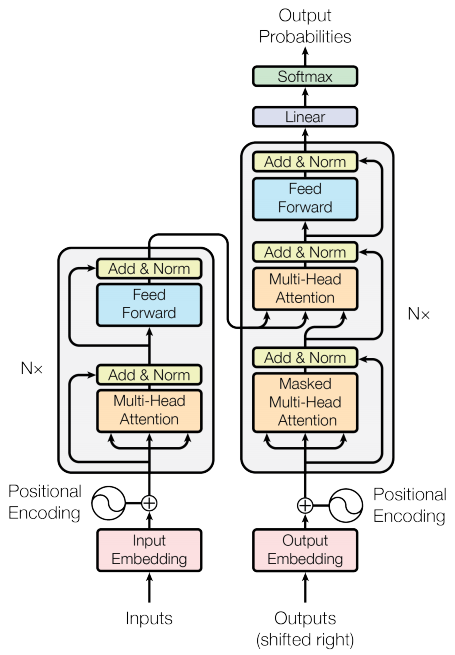

## Part 3: Embeddings and Positional Encoding
- **Embedding:** Learned vector representation of a token where values correspond to similar embeddings within the embedding space.
- **Positional Encoding:** Relate input embeddings such that they also represent their position within the sequence.
    - This is required with transformers because the **entire sequence of embeddings** is input into the transformer, rather than one token at a time.
- **Order-Aware Embedding:** Embedding which has been positionally encoded to be aware of its position within the overall input/output sequence.

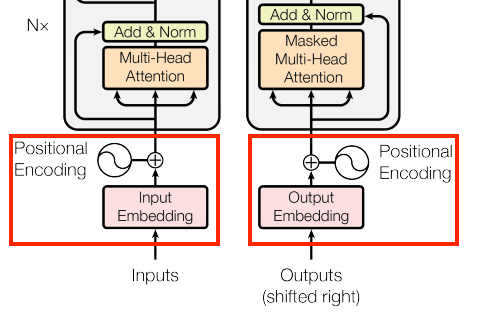

### **Calculation of the Positional Encoding**
Because all the embeddings of the sequence are put in at once, there is not order between the individual tokens. Therefore, they must be positionally encoded. This is done by adding a vector to the original embedding vectors where the positional vectors are found via the following formulas:
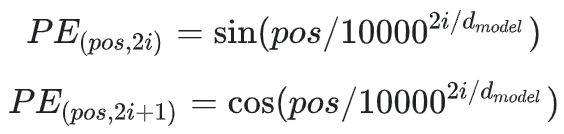

Odd token indeces use the sin() formula, even use cos().

In [13]:
def positional_encoding(length, depth):
    """
    Create a positional encoding
    :param int
    :param int depth: The embedding's depth in the 
    """
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [14]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Based on the embedding associated with a provided token (embedding
    space determined at instantiation), create an order-aware word embedding
    """
    
    def __init__(self, vocab_size, d_model):
        """
        Initialize the layer
        :param int vocab_size: Number of possible tokens
        :param int d_model: Dimensionality of the word embedding vector
        """
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        """
        Calculate the order-aware word embedding from the provided word embedding
        :param tf.Tensor x: Word embedding
        """
        length = tf.shape(x)[1]
        x = self.embedding(x)
        
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [15]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

### Add & Norm Blocks
The Add & Norm blocks are important in regards to the exploding gradient problem (the exploding gradient problem is where the gradient becomes too large, resulting in instability/slow-training) by ensuring the attention mask updates the previous output and is normalized within an effective value bound.

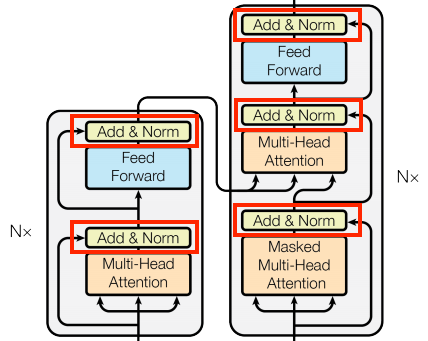

**Implementation:** These are already implemented in tensorflow as the `tf.keras.layers.Add()` and `tf.keras.layers.LayerNormalization()` objects.

## The Attention Layers
There are multiple attention components throughout the architecture of the transformer outlined in the below diagram from the "Attention Is All You Need" paper by Google. Here is a quick refresher on the purose and how-it-words overview of attention:

- **Attention:**
    - **Purpose:** Identify particular components of a vector sequence in order to decrease the overall amount of processing required and decrease the prevelance of irrelevant tokens within the context vectors. 
    - **Self-Attention:** "Self" attention also considers relationships between different parts of the input sequence. This is done by comparing the input sequence against itself by using a similarity function resulting from the inputs of Q, K, and V.
    - **Masked Attention:** Form of attention applied to a masked sequence input. The input sequence is likely masked to prevent the model from later processing particular components such as the actual token it is trying to generate.
    - **Multi-Headed Attention:** Multiple "heads" simply means running multiple attention mechanisms of the same input and then concatenating these results together. This has been shown to capture more complex linguistic phenomena within the sequence.
    
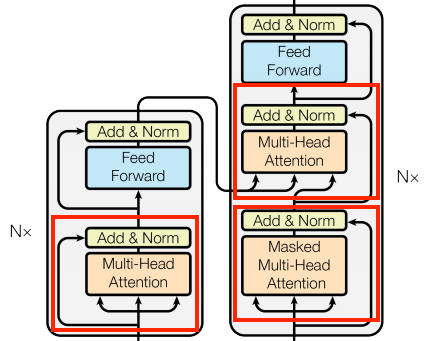

### Understanding Self-Attention
- **Input:** Query (Q), Key (K), and Value (V) matrices which are all embeddings of the input sequence
- **Similarity Function:** The below formula is the scaled dot-product to calculate the attention score for each embedding within the input matrix:
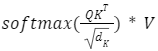
    This works by having the Q and K-transpose get dot-product scores for each embedding vector within the input matrix as a form of "similarity/fuzzy-lookup", these values are then scaled by sqrt(dim-K) and softmaxed to get a probability distribution before mapping to all possible output values, with instensity within the final context-vector output corresponding to each embeddings' attention score from the similarity function (scaled dot-product attention function).
    
    
    
- **Visualization:**
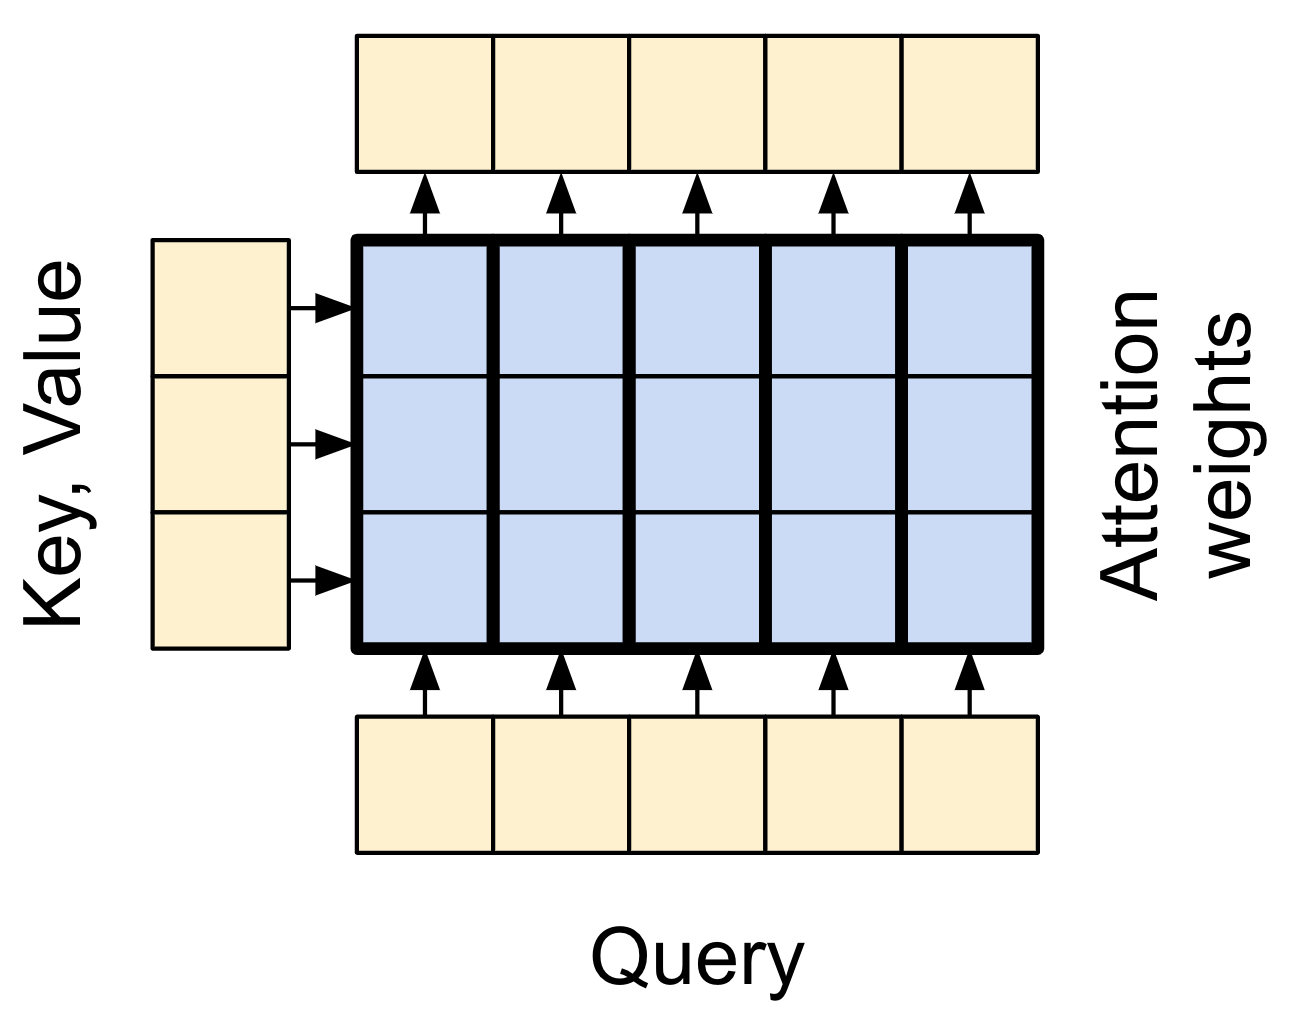
   

**Create a Base-Attention Class to Build Complex Implementations Off Of**

In [16]:
class BaseAttention(tf.keras.layers.Layer):
    """
    Basic form of attention, accepting a varied numbe of inputs
    """
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

**Cross-Attention**<br/>
An attention mechanism which is a part of the decoder portion of the transformer architecture, taking input (Q, K, V) from both the encoder and decoder.

**Read More About This Works Here:** https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [17]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        """
        Calculate the attention mask
        :param tf.Tensor x: Query matrix
        :param tf.Tensor context: The context vector (key/value matrix)
        """
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

**"Global" Self-Attention**<br/>
Self-Attention mechanism in the encoder portion of the transformer architecture.

In [18]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        """
        Responsible for making attention filter mask for creating the
        context sequence used for decoding.
        :param x: Order-Aware word embeddings
        """
        attn_output = self.mha(
            query=x, # as you can see, all Q,V,K are same
            value=x,
            key=x)
        
        # Add & Norm block
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

**"Casual" Self-Attention**<br/>
A model is considered "casual" when it only depends on the previous sequence elements. This attention mechanism is casual because a mask will be placed over the tokens which have not been generated yet (at least in the case of training the transformer and a full target sequence is being input). This is efficient in two ways
- **During Training:** Loss is computed for every location in output sequence while only executing the model just once.
- **During Inference:** Since you're only generating one new token at a time, previous outputs can simply be used to continue "stocking" the output sequence input into the model.

In [19]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        """
        Calculate a masked attention filter for input sequence vectors
        :param tf.Tensor x: Output sequence embeddings
        """
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True) # APPLY MASK
        
        # Add & Norm block
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

## The FeedForward Networks
Included in both the endoder and decorder portions of the transformer architecture, each network is simply made of two dense (linear) layers wiht ReLU activation and dropout. 

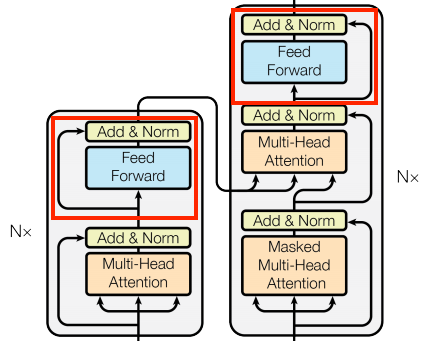<br/>

**Layer Purpose:** Add non-linearity to output, meaning _____.

In [20]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        """
        Create the feed-forward neural network
        :param int d_model: Dimensionality of word embedding
        :param int dff: Number of neurons (dimensionality of FFN)
        """
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'), # 
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        # Add & Norm block
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

## The Encoder Portion
The encoder portion of the transformer (since the encoder-decoder transformer outlined in the "Attention Is All You Need" paper is basically a seq2seq model) is responsible for creating an effective context-vector representation of the input sequence. 

However, there are also multiple encoder layers stacked on top of each other. This means the output of one `EncoderLayer` becomes input to the next `EncoderLayer`, capturing more abstract features of the input.

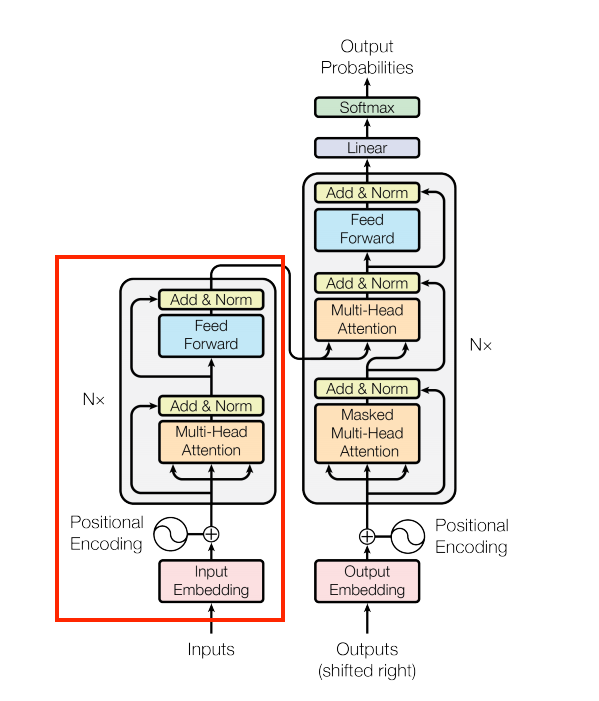

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        """
        Create an encoder layer
        :param int d_model: dimensionality of the word embedding
        :param int num_heads: Number of heads for multi-headed attention
        :param int dff: Number of dense neurons for FFN hidden layer.
        """
        super().__init__()
        
        # Multi-headed attention (Global Self-Attention)
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        # FFN Block
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        # Add & Norm Block
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [22]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        """
        Create the encoder portion of a transformer
        :param int num_layers: Number of `EncoderLayer` to have
        :param int d_model: Dimensionality of word-embedding vector
        :param int num_heads: Number of heads for multi-headed attention
        :param int dff: Number of hidden-layer neurons to have for FFN
        """
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        """
        Run through the encoder portion of a neural network
        :param tf.Tensor x: Matrix representation sequence 
                            of embeddings
        """
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

## The Decoder Portion
The encoder portion of the transformer (since the encoder-decoder transformer outlined in the "Attention Is All You Need" paper is basically a seq2seq model) is responsible for creating an effective output by taking in the context vector of the input sequence and querying which word would make the most sense given the currently seen output sequence.

However, there are also multiple decoder layers stacked on top of each other. This means the output of one `DecoderLayer` becomes input to the next `DecoderLayer`, capturing more abstract features of the input.

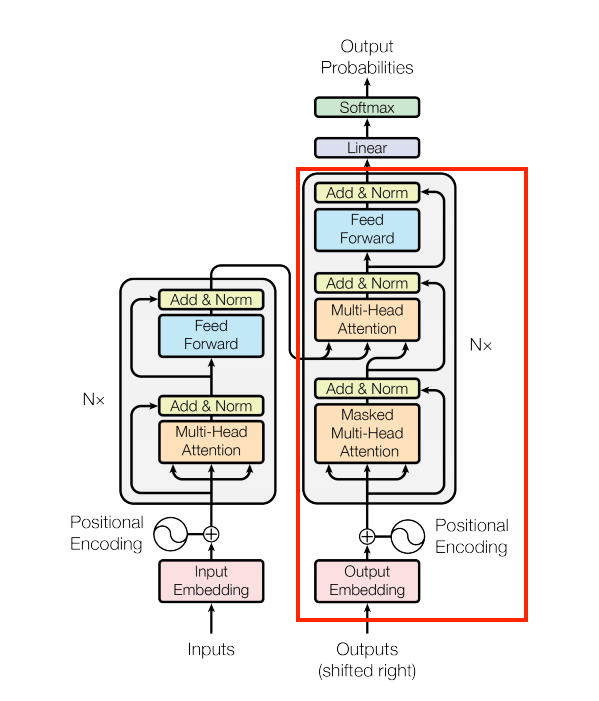

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
        """
        Create a decoder layer
        :param int d_model: dimensionality of the word embedding
        :param int num_heads: Number of heads for multi-headed attention
        :param int dff: Number of dense neurons for FFN hidden layer.
        """
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        # (Visualizing Training)
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [24]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        """
        Create the decoder portion of a transformer
        :param int num_layers: Number of `DecoderLayer` to have
        :param int d_model: Dimensionality of word-embedding vector
        :param int num_heads: Number of heads for multi-headed attention
        :param int dff: Number of hidden-layer neurons to have for FFN
        """
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        """
        Run through the decoder portion of a neural network
        :param tf.Tensor x: Matrix representation sequence 
                            of embeddings for output/target seq
        :param tf.Tensor context: Matrix representation sequence of
                                context vector for embeddings of the
                                input sequence
        """
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
          x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

# Part 4: Building the Transformer
Now that we have specified the individual components of the transformer, we can build the overall transformer and add the final layers to appropriate process both input and output for final language translation.

**To Visualize What Would Be Done if 4-Layer Transformer:**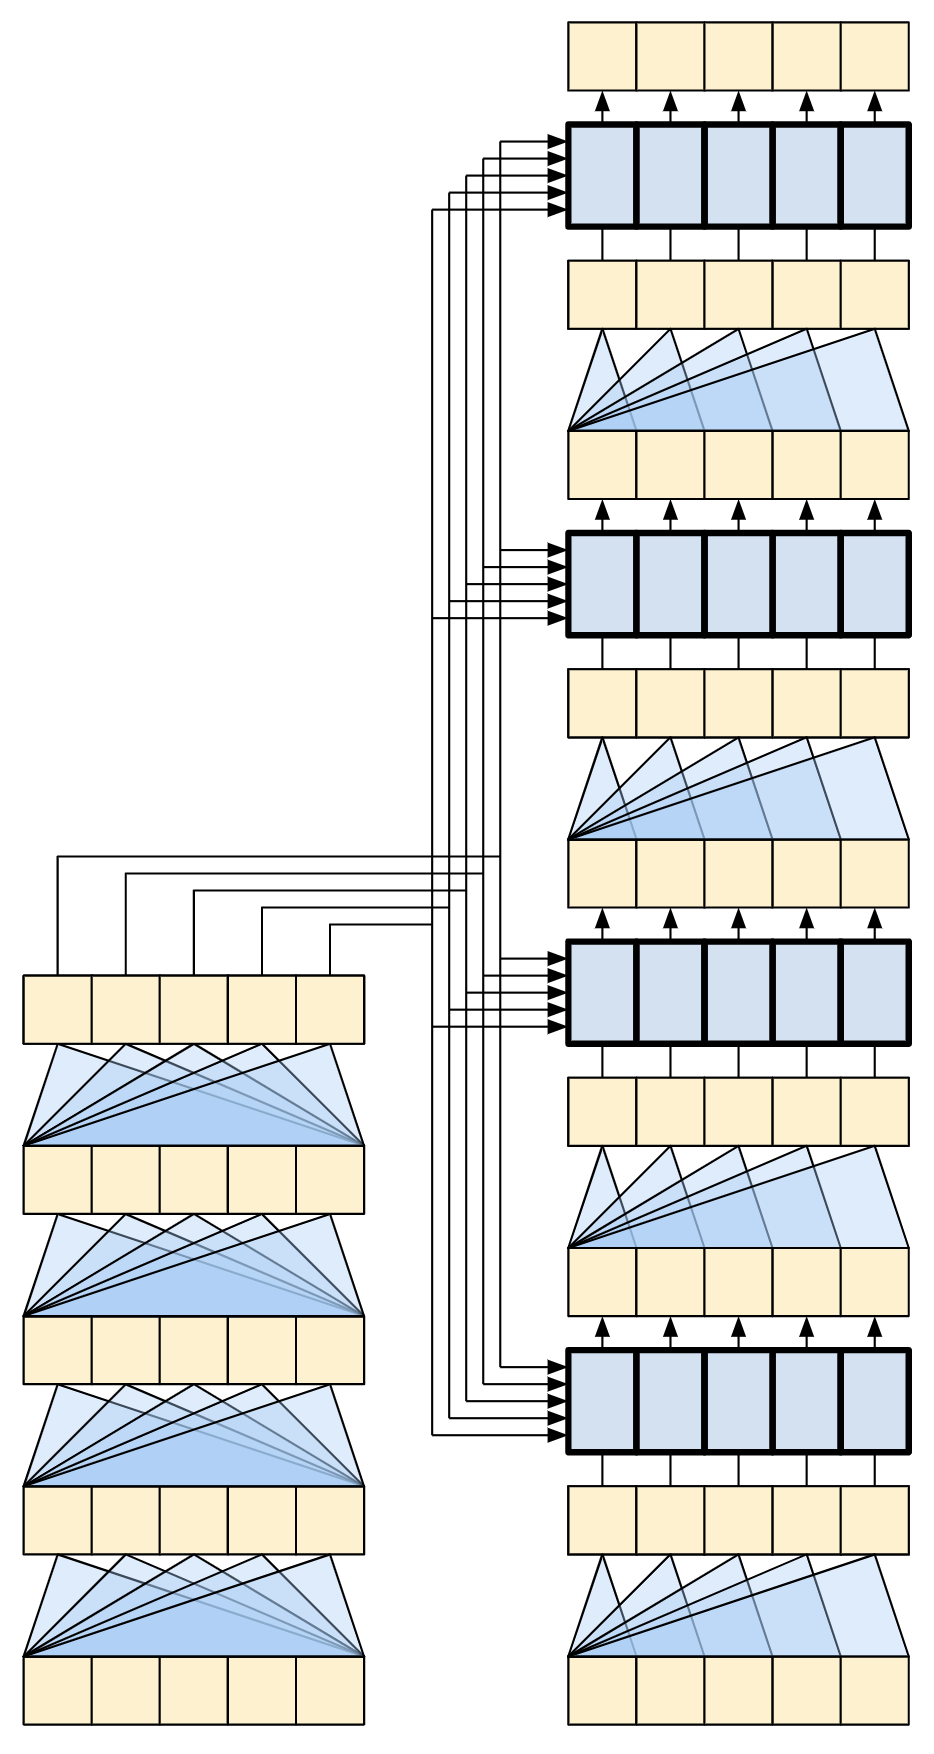

In [25]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

# Part 5: Training w/ Specific Hyperparameters

The optimizer that will be used is Adam; however, it will have a customer learning rate scheduler as outlined in the original "Attention Is All You Need" paper from Google.
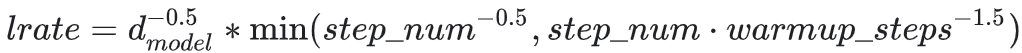

**Command-Line Arguments**<br/>
Allow running this program from a batch script -- be able to use DGX node on ROSIE

In [26]:
# Not specified by command line args
d_model = 128
dff = 512
dropout_rate = 0.1

# Potentionally specified by the command line (default values)
EXP_FOLDER = None
num_epochs = 10
num_layers = 4
num_heads = 8
save_iterations = 10

# Don't Touch -- Only for Batch Job
IS_PYTHON = False

if IS_PYTHON:
    parser = argparse.ArgumentParser()
    parser.add_argument('--exp_name', type=str, default='Experiment') # EXP_FOLDER
    parser.add_argument('--epochs', type=int, default = num_epochs) # num_epochs
    parser.add_argument('--layers', type=int, default = num_layers) # num_layers
    parser.add_argument('--heads', type=int, default = num_heads) # num_heads
    parser.add_argument('--save_iterations', type=int, default = save_iterations) # save_iterations
    
    args = parser.parse_args()
    experiment_name = args.exp_name
    num_epochs = args.epochs
    num_layers = args.layers
    num_heads = args.heads
    save_iterations = args.save_iterations

    # Create folder to hold sbatch runtime data
    # if not os.path.exists('NoFileCreation'):
    now = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
    EXP_FOLDER = experiment_name + ' - ' + str(now)
    os.mkdir(EXP_FOLDER)
    
print("\n")
print("RUN TIME ARGUMENTS: ")
print("EXP FOLDER: ", EXP_FOLDER)
print("NUM EPOCHS: ", num_epochs)
print("NUM LAYERS: ", num_layers)
print("NUM HEADS: ", num_heads)
print("SAVE ITERATIONS: ", save_iterations)
print("\n")



RUN TIME ARGUMENTS: 
EXP FOLDER:  None
NUM EPOCHS:  10
NUM LAYERS:  4
NUM HEADS:  8
SAVE ITERATIONS:  10




In [28]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [29]:
output = transformer((pt, en))
transformer.summary()

2023-05-11 14:06:09.012585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  3632768   
                                                                 
 decoder (Decoder)           multiple                  5647104   
                                                                 
 dense_16 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


**Custom Callback to Monitor Training Progress**<br/>
As the model is training, can save `.h5` file (tf model file), output a graphic of the attention weights for a sample sentence, and output a graphic of the loss in order to monitor the progress of the model's generalization capabilities as the number of epochs increases.

In [ ]:
callbacks = None
if EXP_FOLDER is not None:
    class model_per_epoch(keras.callbacks.Callback):
        """
        Simple callbacks class for transformer.
        Used to save model and display loss throughout training
        following specified save_iterations amount.
        """
        
        def __init__(self, model, filepath):
            """
            Instantiating the callback for the model.
            Outline properties to watch.
            :param tf.Model model: Model this callback is for
            :param str filepath: Filepath model is being saved to
            """
            self.filepath=filepath
            self.model=model
            self.losses = [] # Compile for graphing
            self.current_epoch = 0
        
        def on_epoch_end(self, epoch, logs=None):
            """
            What should occur on epoch end
            :param int epoch: Epoch number
            :param dictionary logs: Logs for the current training
            """
            self.current_epoch = epoch
            if epoch%save_iterations == 0: # Only save/display on save iterations
                # Save the model at epoch
                v_loss=logs.get('val_loss') 
                name= "Epoch" + str(epoch) +'-' + str(v_loss)[:str(v_loss).rfind('.')+3] + '.h5'
                file_id=os.path.join(self.filepath, name)
                self.model.save(file_id)
                
                # Display a loss plot
                self.losses.append(logs.get('val_loss'))
                self._plot_loss()

        def _plot_loss(self):
            """
            Plot the loss function of compiled loss values
            """
            plt.figure()
            plt.plot(np.arange(len(self.losses)), self.losses)
            plt.title('Training Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            
            # Save the plot for later viewing
            plot_name = str(epoch) + 'Epoch_Loss_Plot.png'
            plt.savefig(EXP_FOLDER + '/' + file_name)
                
    save_dir=EXP_FOLDER
    callbacks=[model_per_epoch(transformer, save_dir)]

**Custom Scheduler**<br/>
Based on the "Attention Is All You Need" paper, they used a custom scheduler for their learning rate which consisted of a warm-up period before cooling down as the model converged. The purpose of the warm-up period is so the model can avoid drastic changes during the crucial first stages of developing the weights.

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

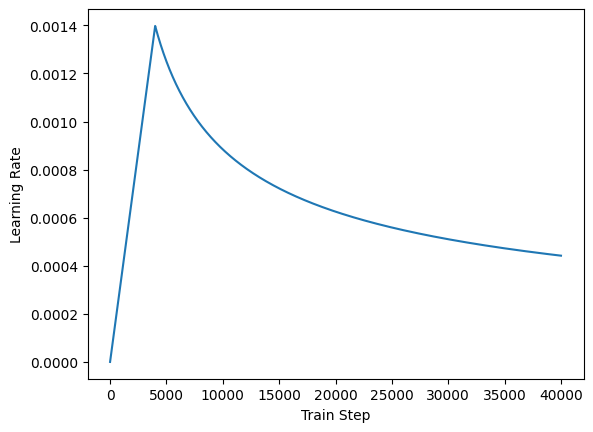

In [31]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [32]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

**Actually Train the Model With Specified Optimizers and Loss Functions**

In [33]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [35]:
history = transformer.fit(train_batches,
                epochs=num_epochs,
                validation_data=val_batches,
                callbacks=callbacks)

Epoch 1/10


2023-05-11 14:06:34.319974: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x4db27660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-11 14:06:34.320046: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-05-11 14:06:34.327086: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-11 14:06:34.508483: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


497/810 [=================>............] - ETA: 1:24 - loss: 7.3604 - masked_accuracy: 0.0975


KeyboardInterrupt



# Part 6: Running Inference
Now that you have a trained model, you'll actually want to see if it appropriately translates Portugese into English!

In [77]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

        tokens = tokenizers.en.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [78]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [79]:
translator = Translator(tokenizers, transformer)

In [80]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


# Part 7: Performance Visualization

### Loss Plots

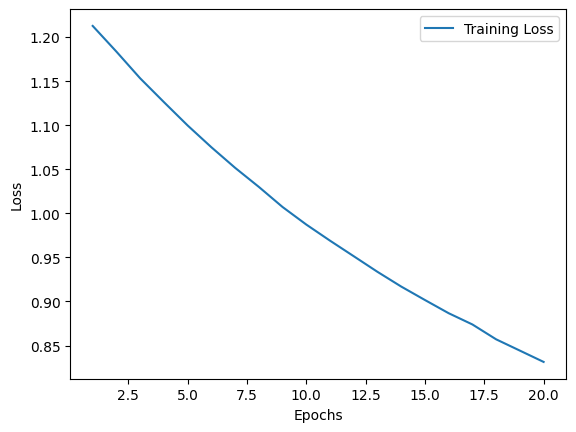

In [76]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Attention Plots

In [68]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
      labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

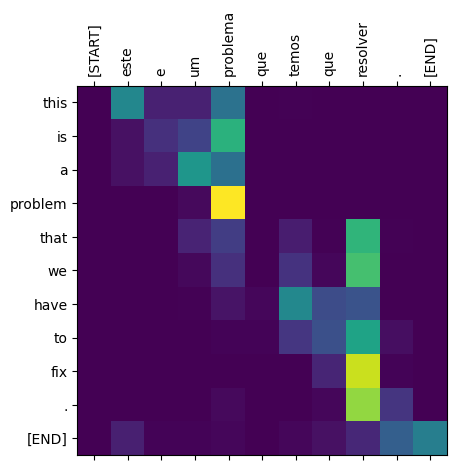

In [70]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

plot_attention_head(in_tokens, translated_tokens, attention)

In [71]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.pt.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

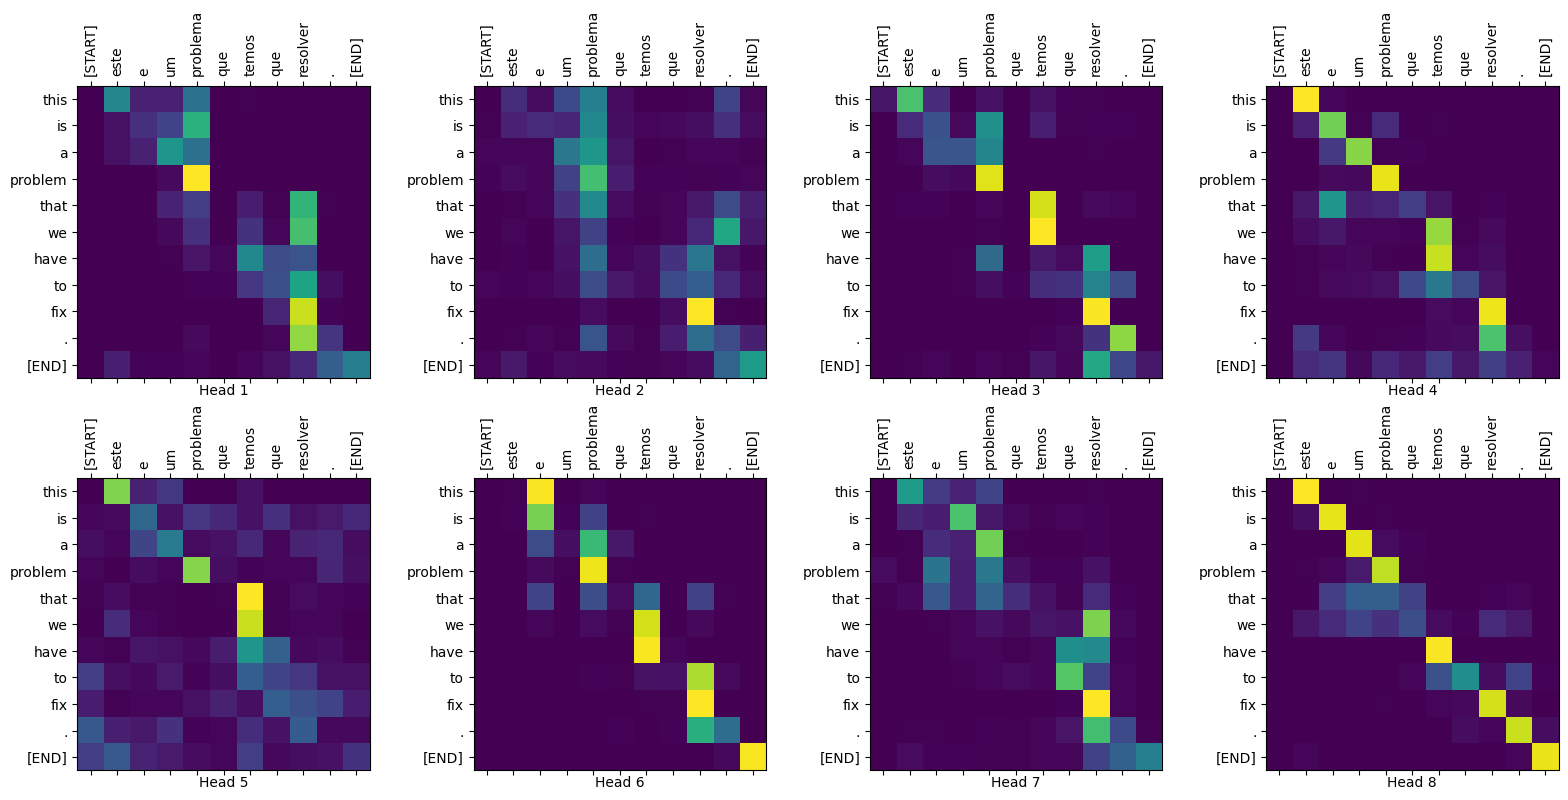

In [72]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])